In [1]:
# We want to load all experiments together into one big dataframe of this shape:
# [ "gsm8k" : ["Llama-3.1-8B-Instruct" : { <experiment_data> },
#               "Qwen-3" : { <experiment_data> }],
#    "creative_writing" : ["Llama-3.1-8B-Instruct" : { <experiment_data> }, 
#                           "Qwen-3" : { <experiment_data> }]
# ]

# And each experiment_data has this shape:
# [ "prompt0" : { <prompt_data> },
#    "prompt1" : { <prompt_data> }
# ]

# And each prompt_data has this shape:
# {
#  "top_p_tokens" : [ <list of lists of top p token ids> ],
#  "top_p_probs"  : [ <list of lists of top p token probabilities (after softmax)> ],
#  "top_p_logits" : [ <list of lists of top p token logits (before softmax)> ],
#  "top_p_generated_tokens" : [ <list of lists of top p tokens decoded> ],
#  "top_p_entropies" : [ <list of entropies of top p tokens> ],
#  "full_entropies"  : [ <list of entropies over full distribution> ],
#   "prompt" : "<prompt that was used>",
#  "correct" : "<did the model answer correct (for math questions)"
# }
# We nedd top_p_tokens
# We dont need top_p_probs (they can be calculated from top_p_logits via softmax)
# We dont need top_p_logits (because we dont look at those for now)
# We dont need top_p_generated_tokens (they can be decoded from top_p_tokens)
# we dont need top_p_entropies (we want to explore full entropy!)
# We need full_entropies, because we cant save all 32k logits to calculate it later.
# we need prompt
# we dont need correct (for now we dont care about that)

#dict_keys(['top_p_tokens', 'top_p_probs', 'top_p_logits', 'generated_tokens', 'entropies', 'cosines', 'prompt', 'correct'])

In [13]:
# Dict[str, Dict[str, List[Dict[str, Tensor]]]]
# dataset_name -> model_name -> list of entries

import os
import torch

# Final structure:
# Dict[str, Dict[str, Dict[str, Any]]]
# results[dataset_name][model_name] = {
#     "file_contents": <string from txt file>,
#     "data": <list of dicts with tensors from .pt>
# }

import numpy as np

def load_results(results_root="results"):
    results = {}

    for dataset_name in os.listdir(results_root):
        dataset_path = os.path.join(results_root, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        results[dataset_name] = {}

        for model_name in os.listdir(dataset_path):
            model_path = os.path.join(dataset_path, model_name)
            if not os.path.isdir(model_path):
                continue

            pt_files = [f for f in os.listdir(model_path) if f.endswith(".pt")]
            txt_files = [f for f in os.listdir(model_path) if f.endswith(".txt")]

            if not pt_files:
                continue
            if len(pt_files) > 1:
                raise ValueError(f"Multiple .pt files in {model_path}, expected only one.")
            if len(txt_files) != 1:
                raise ValueError(f"Expected exactly one .txt file in {model_path}, found {len(txt_files)}.")

            pt_path = os.path.join(model_path, pt_files[0])
            txt_path = os.path.join(model_path, txt_files[0])

            data = torch.load(pt_path)
            with open(txt_path, "r") as f:
                file_contents = f.read()

            results[dataset_name][model_name] = {
                "hf_model_name": file_contents,
                "data": data
            }

    return results


In [16]:
# The reason we have to precompute the cosines during training is that 
# we need the model embedding layer to produce the vector embeddings. 
# The tokenizer doesnt have that, only the model

import matplotlib.pyplot as plt
import numpy as np

def process_experiment_results(experiment_results, remove_zero_one_points):
    entropies = []
    cosines = []

    for prompt_result in experiment_results["data"]:
        prompt_entropies = prompt_result["entropies"]
        prompt_cosines = prompt_result["cosines"]
        entropies.extend(prompt_entropies)
        cosines.extend(prompt_cosines)
    
    entropies = np.array(entropies, dtype=float)
    cosines = np.array(cosines, dtype=float)

    #mask = (entropies == 0) & np.isnan(cosines)
    #cosines[mask] = 1.0

    
    if remove_zero_one_points:
        mask = ~((entropies == 0) & (cosines == 1))
        entropies = entropies[mask]
        cosines = cosines[mask]

    # compute pearson and spearman
    from scipy.stats import pearsonr
    r, p = pearsonr(entropies, cosines)
    print("pearson coefficient")
    print(r)
    print(p)
    from scipy.stats import spearmanr
    rho, p = spearmanr(entropies, cosines)
    print("Spearman coefficient")
    print(rho)
    print(p)


    #coeffs = np.polyfit(entropies, cosines, deg=4)
    #print(coeffs)
    # Generate x values from 0 to 1
    #x_fit = np.linspace(0, 8, 500)

    # Compute the polynomial values
    #y_fit = np.polyval(coeffs, x_fit)

    # Plot
    #plt.figure(figsize=(8, 5))
    #plt.plot(x_fit, y_fit, label='Cubic Polynomial Fit', color='darkred')
    #plt.xlabel("Normalized X")
    #plt.ylabel("Predicted Y")
    #plt.title("Cubic Polynomial Regression Fit")
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()


    # Create scatter plot
    #plt.figure(figsize=(8, 6))
    #plt.scatter(entropies, cosines, alpha=0.1)
    #plt.xlabel('Entropy')
    #plt.ylabel('Cosine Similarity')
    #plt.title('Entropy vs. Cosine Similarity')
    #plt.tight_layout()
    #plt.show()
    # Create line plot

    from scipy.stats import binned_statistic

    # Assuming entropies and cosines are already numpy arrays
    num_bins = 50
    bin_means, bin_edges, _ = binned_statistic(entropies, cosines, statistic='mean', bins=num_bins)
    bin_medians, _, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)

    # Compute standard deviation per bin
    bin_indices = np.digitize(entropies, bin_edges)
    bin_std = np.zeros(num_bins)
    for i in range(1, num_bins + 1):
        bin_values = cosines[bin_indices == i]
        if len(bin_values) > 0:
            bin_std[i-1] = np.std(bin_values)

    # Bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, bin_medians, label='Median Cosine Similarity', color='blue')
    plt.fill_between(bin_centers,
                    bin_medians - bin_std,
                    bin_medians + bin_std,
                    color='blue',
                    alpha=0.2,
                    label='±1 Std Dev')
    plt.xlabel('Entropy')
    plt.ylabel('Cosine Similarity')
    plt.title('Entropy vs. Cosine Similarity (Median ± Std Dev)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    


Dataset: writingprompts Model: Mistral-7B-v0.1
pearson coefficient
-0.49438448105098864
0.0
Spearman coefficient
-0.6615590611124486
0.0


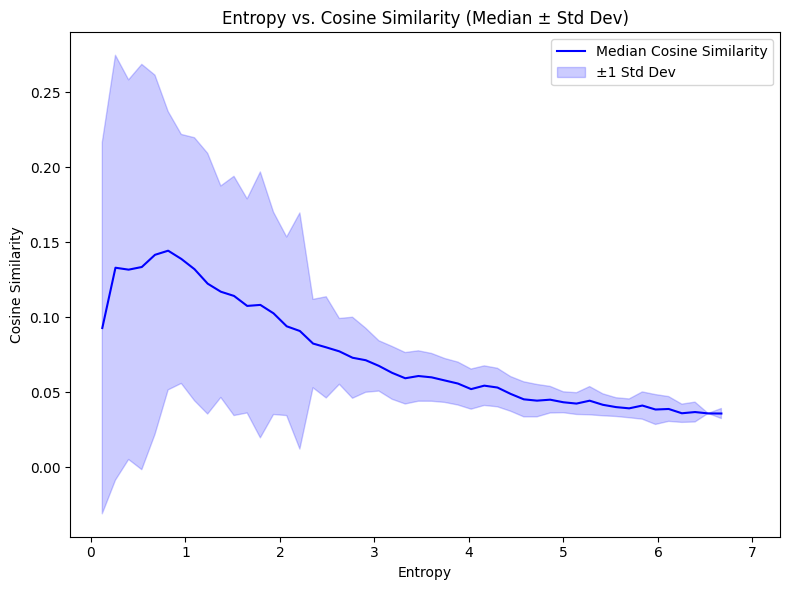

Dataset: writingprompts Model: Llama-3.1-8B-Instruct
pearson coefficient
-0.5755677712389228
0.0
Spearman coefficient
-0.7046207864401464
0.0


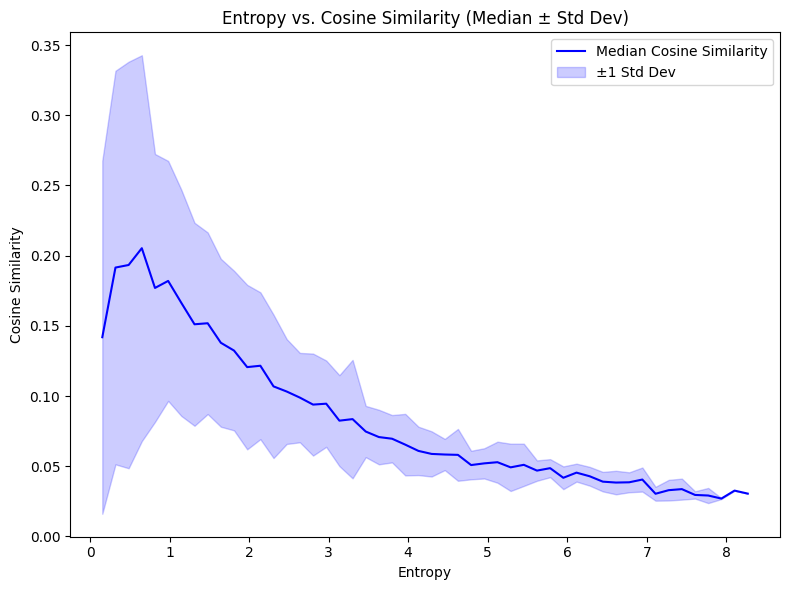

Dataset: writingprompts Model: deepseek-llm-7b-base
pearson coefficient
-0.43267674033139636
0.0
Spearman coefficient
-0.6721580073105993
0.0


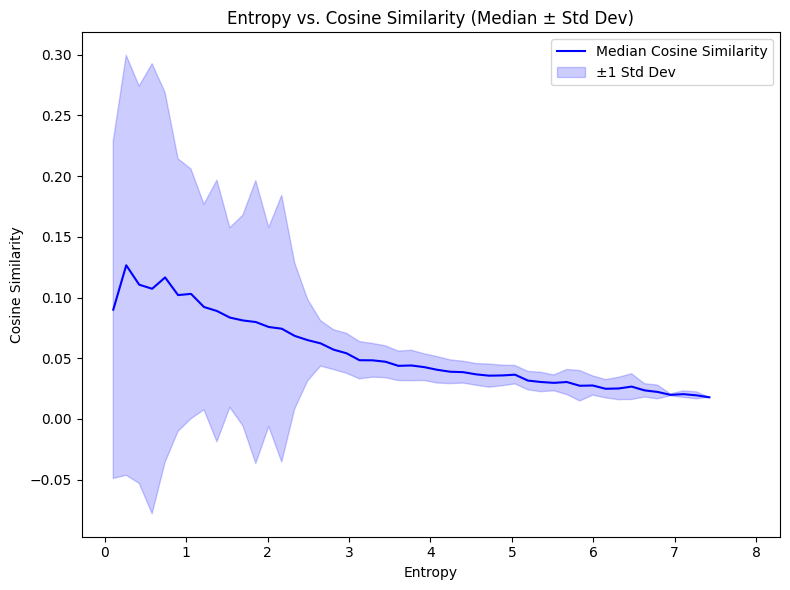

Dataset: gsm8k Model: Mistral-7B-v0.1
pearson coefficient
-0.502632872581983
0.0
Spearman coefficient
-0.6667441875056445
0.0


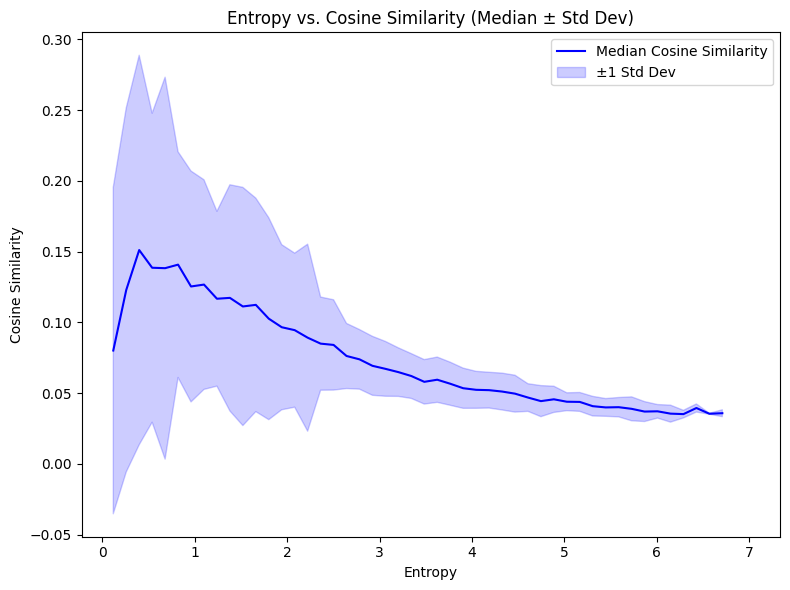

Dataset: gsm8k Model: Llama-3.1-8B-Instruct
pearson coefficient
-0.5696316791635304
0.0
Spearman coefficient
-0.70058902024782
0.0


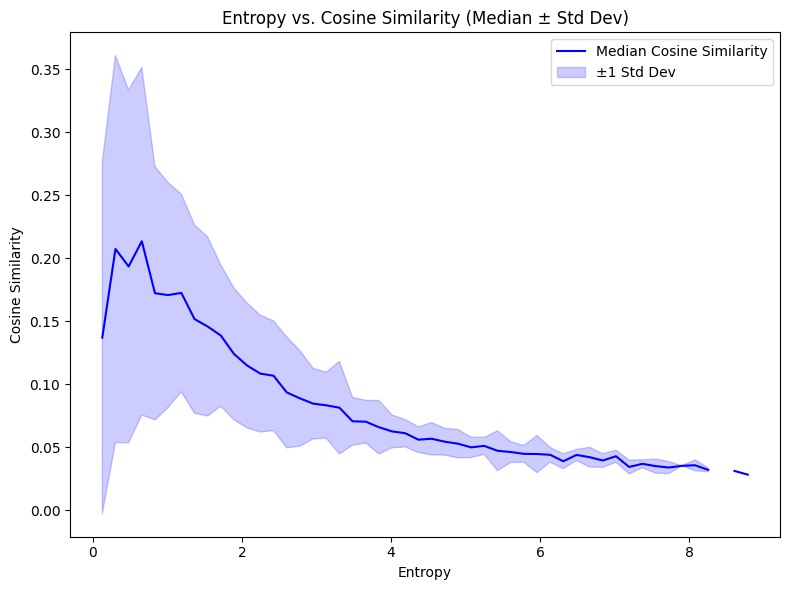

Dataset: gsm8k Model: deepseek-llm-7b-base
pearson coefficient
-0.4246470514174465
0.0
Spearman coefficient
-0.6476114563645405
0.0


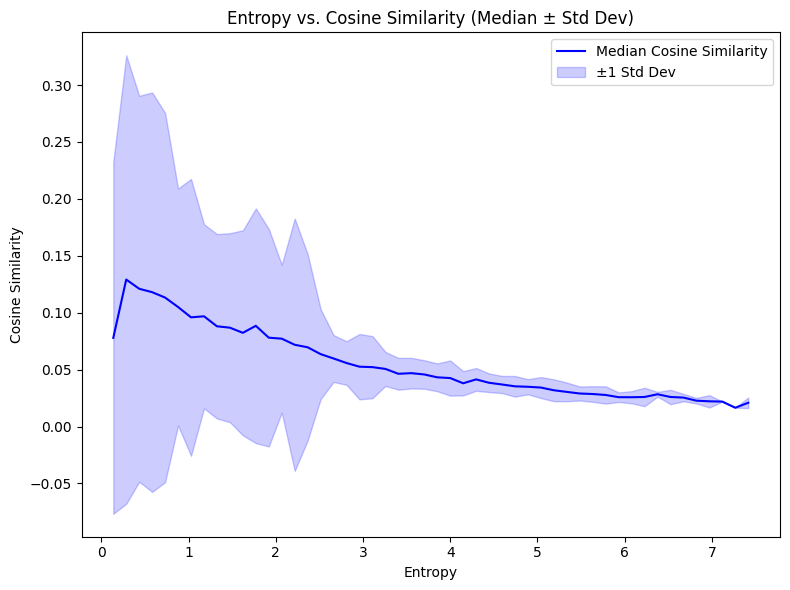

Dataset: xsum Model: Mistral-7B-v0.1
pearson coefficient
-0.5121482174609391
0.0
Spearman coefficient
-0.6663881528948434
0.0


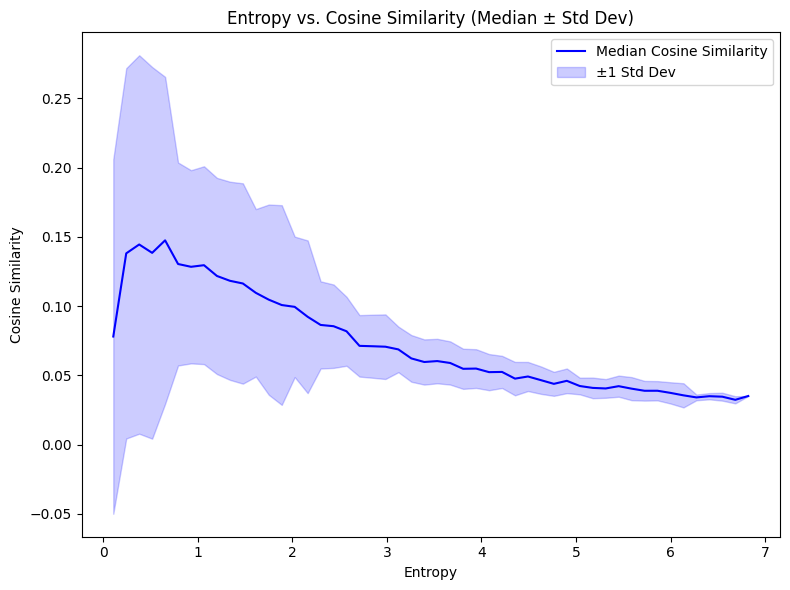

Dataset: xsum Model: Llama-3.1-8B-Instruct
pearson coefficient
-0.570677735071012
0.0
Spearman coefficient
-0.6932451494817724
0.0


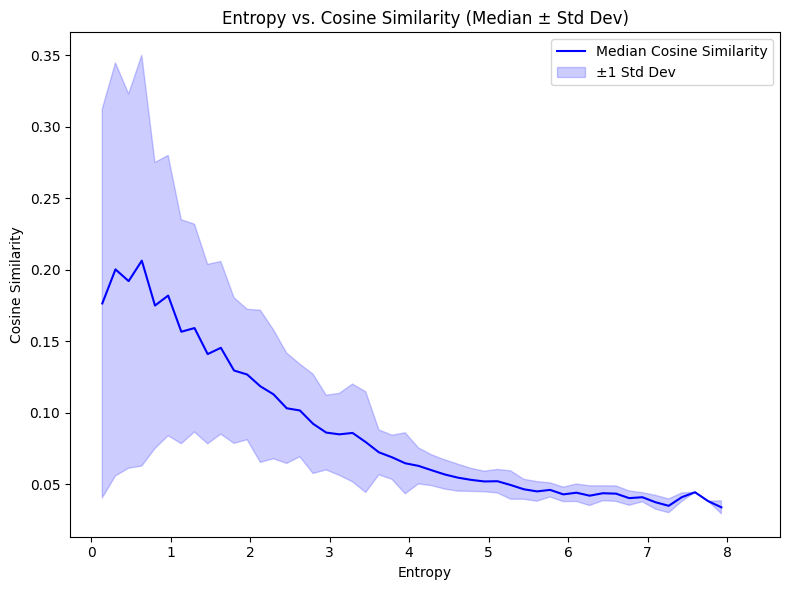

Dataset: xsum Model: deepseek-llm-7b-base
pearson coefficient
-0.4485118949011973
0.0
Spearman coefficient
-0.6663476224299872
0.0


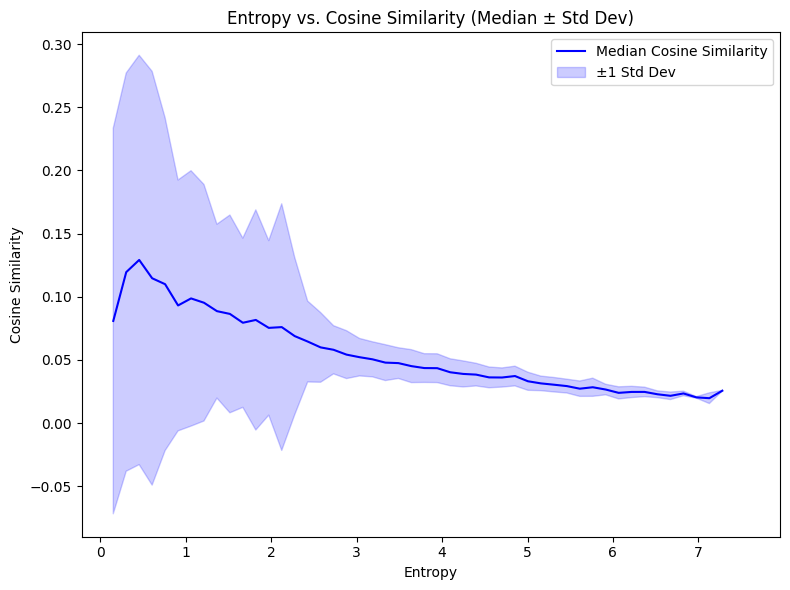

In [15]:
root_dir = "results/"
results = load_results()
for dataset_name in os.listdir(root_dir):
    dataset_path = os.path.join(root_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    for model_name in os.listdir(dataset_path):
        model_path = os.path.join(dataset_path, model_name)
        if not os.path.isdir(model_path):
            continue

        print(f"Dataset: {dataset_name} Model: {model_name}")
        experiment_results = results[dataset_name][model_name]
        process_experiment_results(experiment_results, True)


        #TODO vlt der grund warum es wenn entropy ~0 ist, die cosine runtergeht, ist weil dann es nur ein passendes token gibt mit hoher Wkt
        # und das zweitbeste token ist sehr unsimilar aber hat dafür eine kleine Wkt. 

        #TODO spearman misst monotonie, pearson misst linear (in etwa)
        # Da spearman stärker ist bei uns, kann es zeigen dass es monoton beziehung ist, die aber nicht perfekt linear ist

/tmp/ipykernel_20942/689304367.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  model_colors = dict(zip(models, cm.get_cmap("tab10").colors[:len(models)]))


Dataset: gsm8k Model: Llama-3.1-8B-Instruct
  Pearson r=-0.570, Spearman rho=-0.701
Dataset: gsm8k Model: Mistral-7B-v0.1
  Pearson r=-0.503, Spearman rho=-0.667
Dataset: gsm8k Model: Qwen3-8B
  Pearson r=-0.365, Spearman rho=-0.392
Dataset: gsm8k Model: deepseek-llm-7b-base
  Pearson r=-0.425, Spearman rho=-0.648
Dataset: writingprompts Model: Llama-3.1-8B-Instruct
  Pearson r=-0.576, Spearman rho=-0.705
Dataset: writingprompts Model: Mistral-7B-v0.1
  Pearson r=-0.494, Spearman rho=-0.662
Dataset: writingprompts Model: Qwen3-8B
  Pearson r=-0.380, Spearman rho=-0.410
Dataset: writingprompts Model: deepseek-llm-7b-base
  Pearson r=-0.433, Spearman rho=-0.672
Dataset: xsum Model: Llama-3.1-8B-Instruct
  Pearson r=-0.571, Spearman rho=-0.693
Dataset: xsum Model: Mistral-7B-v0.1
  Pearson r=-0.512, Spearman rho=-0.666
Dataset: xsum Model: Qwen3-8B
  Pearson r=-0.373, Spearman rho=-0.429
Dataset: xsum Model: deepseek-llm-7b-base
  Pearson r=-0.449, Spearman rho=-0.666


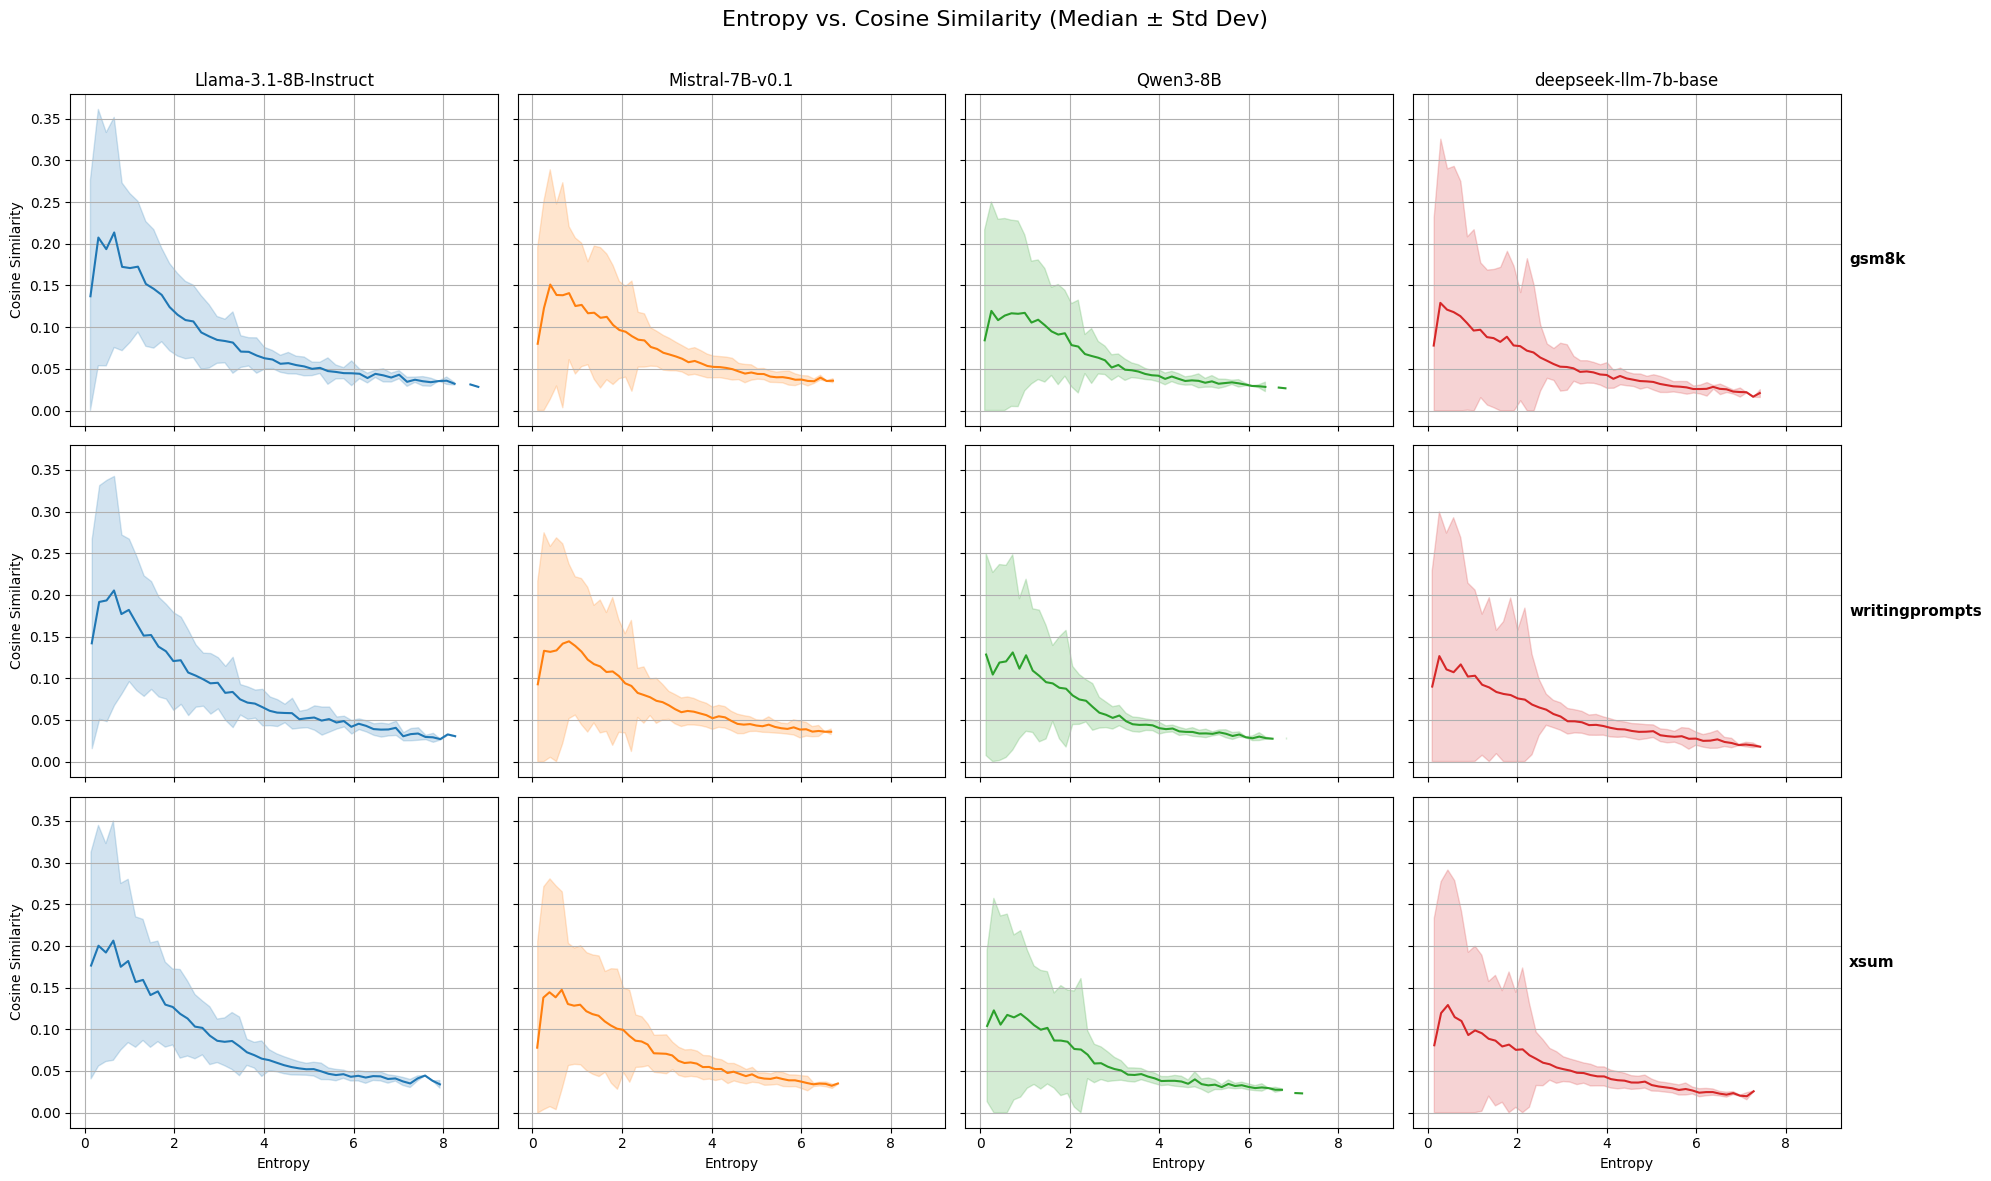

In [22]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic, pearsonr, spearmanr
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def process_and_collect(experiment_results, remove_zero_one_points):
    entropies = []
    cosines = []

    for prompt_result in experiment_results["data"]:
        entropies.extend(prompt_result["entropies"])
        cosines.extend(prompt_result["cosines"])

    entropies = np.array(entropies, dtype=float)
    cosines = np.array(cosines, dtype=float)

    if remove_zero_one_points:
        mask = ~((entropies == 0) & (cosines == 1))
        entropies = entropies[mask]
        cosines = cosines[mask]

    # Stats
    r, p = pearsonr(entropies, cosines)
    rho, p2 = spearmanr(entropies, cosines)
    print(f"  Pearson r={r:.3f}, Spearman rho={rho:.3f}")

    # Binning
    num_bins = 50
    bin_medians, bin_edges, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)
    bin_indices = np.digitize(entropies, bin_edges)
    bin_std = np.zeros(num_bins)
    for i in range(1, num_bins + 1):
        bin_values = cosines[bin_indices == i]
        if len(bin_values) > 0:
            bin_std[i-1] = np.std(bin_values)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return bin_centers, bin_medians, bin_std


root_dir = "results/"
results = load_results()

# Collect datasets/models
datasets = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
models = set()
for d in datasets:
    d_path = os.path.join(root_dir, d)
    for m in os.listdir(d_path):
        if os.path.isdir(os.path.join(d_path, m)):
            models.add(m)
models = sorted(list(models))

# Assign fixed color per model
model_colors = dict(zip(models, cm.get_cmap("tab10").colors[:len(models)]))

# Setup grid
fig, axes = plt.subplots(len(datasets), len(models), figsize=(5 * len(models), 4 * len(datasets)), sharex=True, sharey=True)
if len(datasets) == 1 and len(models) == 1:
    axes = np.array([[axes]])
elif len(datasets) == 1:
    axes = axes[np.newaxis, :]
elif len(models) == 1:
    axes = axes[:, np.newaxis]

for i, dataset_name in enumerate(datasets):
    for j, model_name in enumerate(models):
        ax = axes[i][j]
        model_path = os.path.join(root_dir, dataset_name, model_name)
        if not os.path.isdir(model_path):
            ax.set_visible(False)
            continue

        print(f"Dataset: {dataset_name} Model: {model_name}")
        experiment_results = results[dataset_name][model_name]
        bin_centers, bin_medians, bin_std = process_and_collect(experiment_results, True)

        lower = np.clip(bin_medians - bin_std, 0, None)
        upper = bin_medians + bin_std
        color = model_colors[model_name]

        ax.plot(bin_centers, bin_medians, label=model_name, color=color)
        ax.fill_between(bin_centers, lower, upper, alpha=0.2, color=color)
        # Left-side label: cosine similarity
        if j == 0:
            ax.set_ylabel("Cosine Similarity")

        # Right-side dataset name label
        if j == len(models) - 1:
            ax.text(1.02, 0.5, dataset_name,
                    transform=ax.transAxes,
                    fontsize=11, fontweight='bold',
                    va='center', ha='left')

        if i == len(datasets) - 1:
            ax.set_xlabel("Entropy")
        if i == 0:
            ax.set_title(model_name)

        ax.grid(True)

# Shared legend (optional, add outside grid if needed)
# fig.legend(models, loc="upper right")

plt.suptitle("Entropy vs. Cosine Similarity (Median ± Std Dev)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
